In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import math
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline
#device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu"
print(device)

cpu


## create dataset

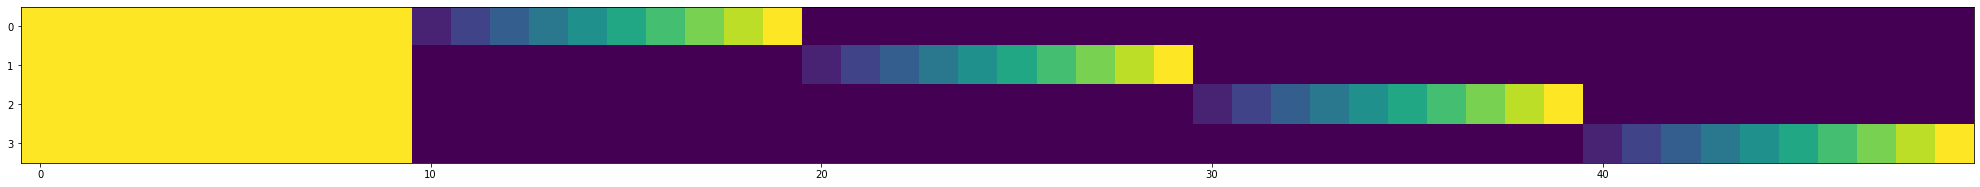

In [8]:
seq_class = []
total_tokens = 50
offset = 10 

for i in range(4):
    temp = np.zeros(total_tokens)
    temp[:offset] = 1
    temp[(i+1)*offset:((i+2)*offset)] = np.arange(0.1,1.1,0.1)
    temp = temp/sum(temp)
    seq_class.append(temp)
    assert(sum(seq_class[i])==1)
plt.figure(figsize=(35,10))
plt.imshow(np.vstack(seq_class))
    
def sample_sequence(next_token,seq_len):
    '''
    function to sample a sequence based on p(l|m,n) for given m and n.
    '''
    query_tokens = [5,6,7,8]
    next_tokens = [1,2,3,4]
    if next_token==next_tokens[0]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[0],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[0],next_token])
    if next_token==next_tokens[1]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[1],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[1],next_token])
    if next_token==next_tokens[2]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[2],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[2],next_token])
    if next_token==next_tokens[3]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[3],size=seq_len-2)
        seq = np.append(context_tokens,[query_tokens[3],next_token])
    return seq

def generate_data(batch_size,seq_len):
    batch_of_seq = []
    next_tokens = [1,2,3,4]
    for i in range(batch_size):
        next_token = np.random.choice(next_tokens,p=[0.25]*4)
        generated_seq = sample_sequence(next_token,seq_len)
        batch_of_seq.append(torch.tensor(generated_seq))
    return torch.vstack(batch_of_seq)


def analyse_model(model,batch_size,seq_len):
    test_inputs = generate_data(batch_size,seq_len)
    tinputs,tlabels  = test_inputs[:,:-1].to(device),test_inputs[:,-1].to(device)
    
    model.eval()
    with torch.no_grad():
        model_output,model_attention = model(tinputs)
    #model_output = nn.Softmax(dim=1)(model_output)

    common_tokens_attn = []
    distinct_tokens_attn = []
    for i in range(batch_size):
        indices_1 = torch.logical_and(tinputs[i]>=0,tinputs[i]<10)
        indices_2 = torch.logical_and(tinputs[i]>=10,tinputs[i]<50)
        common_tokens_attn.append(sum(model_attention[i][indices_1]).item())
        distinct_tokens_attn.append(sum(model_attention[i][indices_2]).item())
    return np.mean(common_tokens_attn),np.mean(distinct_tokens_attn)


class Net_p1(nn.Module):
    def __init__(self):
        super(Net_p1,self).__init__()
        self.key_layer = nn.Linear(50,50,bias=False)
        self.query_layer = nn.Linear(50,50,bias=False)
        self.value_layer = nn.Linear(50,50,bias=False)
        self.prediction_layer = nn.Linear(50,50,bias=False)
        
        #self.key_query_layer.weight = nn.Parameter(torch.zeros(50,50))
        self.key_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.value_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.prediction_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
    def forward(self,x):
        batch,seq_len,vocab_size = x.shape
        
        key = self.key_layer(x)
        query = torch.unsqueeze(self.query_layer(x[:,-1]),dim=1)
        
        #print(key.shape,query.shape)
        scores = (query@key.transpose(-2,-1))*(1/math.sqrt(key.size(-1)))
        
        
        
        
        attn = nn.Softmax(dim=-1)(scores)
        x1 = self.value_layer(x)
        context =torch.matmul(attn,x1)
    
        output = self.prediction_layer(context)
        #print(output.shape)
        return output[:,0,:],attn[:,0,:]
    
class Net_p2(nn.Module):
    def __init__(self):
        super(Net_p2,self).__init__()
        self.key_layer = nn.Linear(50,50,bias=False)
        self.query_layer = nn.Linear(50,50,bias=False)
        #self.value_layer = nn.Linear(50,50,bias=False)
        self.prediction_layer = nn.Linear(50,50,bias=False)
        
        #self.key_query_layer.weight = nn.Parameter(torch.zeros(50,50))
        self.key_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        #self.value_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.prediction_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
    def forward(self,x):
        batch,seq_len,vocab_size = x.shape
        
        key = self.key_layer(x)
        query = torch.unsqueeze(self.query_layer(x[:,-1]),dim=1)
        
        #print(key.shape,query.shape)
        scores = (query@key.transpose(-2,-1))*(1/math.sqrt(key.size(-1)))
        
        
        
        
        attn = nn.Softmax(dim=-1)(scores)
        x1 = x #self.value_layer(x)
        context =torch.matmul(attn,x1)
    
        output = self.prediction_layer(context)
        #print(output.shape)
        return output[:,0,:],attn[:,0,:]



In [9]:
def generate_heatmap(model,epoch_no):
    model.eval()
    attn_values = []
    prediction  = []
    with torch.no_grad():
        running_loss = 0.0
        for j in range(200):
            data = generate_data(batch_size,seq_len)
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            indices = inputs>9
            inputs = F.one_hot(inputs,num_classes=50).float()
            outputs,attn  = model(inputs)
            #print(outputs.shape)
            outputs = nn.Softmax(dim=1)(outputs)
            #print(outputs[np.arange(128),labels])
            #print(outputs.shape)

            for i in range(outputs.shape[0]):
                attn_values.append(sum(attn[i][indices[i]]).item())
                prediction.append(outputs[i,labels[i]].item())
    return attn_values,prediction

## FAFO

In [4]:
n_epochs = 1000
n_batches = 100

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236]

Attn_Values  = []
Prediction_Values = []
#deltas_list = []
for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p1().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=1e-2)

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    #deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # record conservation error
#         with torch.no_grad():
#             C1 = model.value_layer.weight.matmul(model.value_layer.weight.t())
#             C2 = model.prediction_layer.weight.t().matmul(model.prediction_layer.weight)
            
#             denom = max(torch.norm(C1).item(), torch.norm(C2).item(), epsilon)
#             delta = torch.norm(C2 - C1).item() / denom
#             deltas.append(delta)
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        if (running_loss/n_batches)<=0.001:
            break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

 10%|████                                    | 100/1000 [01:24<13:16,  1.13it/s]

[100,  100] loss:3.912


 20%|████████                                | 200/1000 [02:50<12:17,  1.08it/s]

[200,  100] loss:2.641


 30%|██████████▏                       | 300/1000 [3:55:50<48:34:54, 249.85s/it]

[300,  100] loss:1.396


 40%|█████████████▌                    | 400/1000 [8:01:06<28:16:54, 169.69s/it]

[400,  100] loss:1.390


 50%|██████████████████▌                  | 500/1000 [11:30:58<27:59,  3.36s/it]

[500,  100] loss:1.180


 60%|██████████████████████▏              | 600/1000 [11:32:06<05:41,  1.17it/s]

[600,  100] loss:0.161


 70%|█████████████████████████▉           | 700/1000 [11:33:23<04:19,  1.16it/s]

[700,  100] loss:0.031


 80%|█████████████████████████████▌       | 800/1000 [11:34:51<02:57,  1.13it/s]

[800,  100] loss:0.016


 90%|█████████████████████████████████▎   | 900/1000 [11:36:18<01:28,  1.14it/s]

[900,  100] loss:0.011


100%|████████████████████████████████████| 1000/1000 [11:37:45<00:00, 41.87s/it]

[1000,  100] loss:0.008
Finished Training



 10%|████                                    | 100/1000 [01:20<13:06,  1.14it/s]

[100,  100] loss:3.912


 20%|████████                                | 200/1000 [02:43<12:01,  1.11it/s]

[200,  100] loss:2.641


 30%|████████████                            | 300/1000 [04:05<06:25,  1.82it/s]

[300,  100] loss:1.396


 40%|████████████████                        | 400/1000 [05:29<08:59,  1.11it/s]

[400,  100] loss:1.390


 50%|████████████████████                    | 500/1000 [06:59<07:33,  1.10it/s]

[500,  100] loss:1.180


 60%|████████████████████████                | 600/1000 [08:30<06:05,  1.10it/s]

[600,  100] loss:0.162


 70%|████████████████████████████            | 700/1000 [10:02<04:53,  1.02it/s]

[700,  100] loss:0.031


 80%|████████████████████████████████        | 800/1000 [11:39<03:15,  1.02it/s]

[800,  100] loss:0.016


 90%|████████████████████████████████████    | 900/1000 [13:16<01:39,  1.00it/s]

[900,  100] loss:0.011


100%|███████████████████████████████████████| 1000/1000 [14:53<00:00,  1.12it/s]

[1000,  100] loss:0.008
Finished Training



 10%|████                                    | 100/1000 [01:37<14:39,  1.02it/s]

[100,  100] loss:3.912


 20%|████████                                | 200/1000 [03:13<13:06,  1.02it/s]

[200,  100] loss:2.641


 30%|████████████                            | 300/1000 [04:50<11:23,  1.02it/s]

[300,  100] loss:1.396


 40%|████████████████                        | 400/1000 [06:26<09:42,  1.03it/s]

[400,  100] loss:1.390


 50%|████████████████████                    | 500/1000 [07:29<07:52,  1.06it/s]

[500,  100] loss:1.180


 60%|████████████████████████                | 600/1000 [09:02<06:03,  1.10it/s]

[600,  100] loss:0.162


 70%|████████████████████████████            | 700/1000 [10:33<04:40,  1.07it/s]

[700,  100] loss:0.031


 80%|████████████████████████████████        | 800/1000 [12:06<03:18,  1.01it/s]

[800,  100] loss:0.016


 90%|████████████████████████████████████    | 900/1000 [13:46<01:41,  1.01s/it]

[900,  100] loss:0.011


100%|███████████████████████████████████████| 1000/1000 [15:25<00:00,  1.08it/s]

[1000,  100] loss:0.008
Finished Training


In [5]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

loss:0.007
accuracy:1.000


In [6]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params1.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(std_hist_norm, dtype=object)
for i in range(std_hist_norm.shape[0]):
    for j in range(std_hist_norm.shape[1]):
        annot_array[i, j] = f"±{std_hist_norm[i, j]:.1f}"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(std_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params1_std.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# torch.manual_seed(1234)
# model = Net_p1().to(device)
model.eval()
attn_values = []
prediction  = []
with torch.no_grad():
    running_loss = 0.0
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        indices = inputs>9
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        #print(outputs.shape)
        outputs = nn.Softmax(dim=1)(outputs)
        #print(outputs[np.arange(128),labels])
        
        for i in range(attn.shape[0]):
            attn_values.append(sum(attn[i][indices[i]]).item())
            prediction.append(outputs[i,labels[i]].item())


In [ ]:
attn_values = np.array(attn_values)[None,:]
prediction = np.array(prediction)[None,:]

In [ ]:
num = 160
histograms = []
for attn, pred in zip(attn_values, prediction):
    hist, _, _ = np.histogram2d(attn, pred, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}" #\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params1_test.pdf", bbox_inches='tight')
plt.show()


## FACO

In [ ]:
n_epochs = 2500
n_batches = 250

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236]

Attn_Values  = []
Prediction_Values = []
#deltas_list = []
for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=1e-2)

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    #deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # record conservation error
#         with torch.no_grad():
#             C1 = model.value_layer.weight.matmul(model.value_layer.weight.t())
#             C2 = model.prediction_layer.weight.t().matmul(model.prediction_layer.weight)
            
#             denom = max(torch.norm(C1).item(), torch.norm(C2).item(), epsilon)
#             delta = torch.norm(C2 - C1).item() / denom
#             deltas.append(delta)
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        if (running_loss/n_batches)<=0.001:
            break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

In [ ]:
# plt.plot(deltas_list[2])
# plt.ylabel(r"$\Delta$")
# plt.xlabel("epochs")
# plt.savefig("conserve_quantity.pdf")

In [ ]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

In [ ]:
#  sum(((np.array(Attn_Values[0]) + np.array(Attn_Values[1]) +  
#        np.array(Attn_Values[2]) +  np.array(Attn_Values[3]) +  
#        np.array(Attn_Values[4]) ) /5)>=0.4)

In [ ]:
#generate_heatmap(model,epoch+1)

In [ ]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params2.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(std_hist_norm, dtype=object)
for i in range(std_hist_norm.shape[0]):
    for j in range(std_hist_norm.shape[1]):
        annot_array[i, j] = f"±{std_hist_norm[i, j]:.1f}"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(std_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params2_std.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# torch.manual_seed(1234)
# model = Net_p1().to(device)
model.eval()
attn_values = []
prediction  = []
with torch.no_grad():
    running_loss = 0.0
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        indices = inputs>9
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        #print(outputs.shape)
        outputs = nn.Softmax(dim=1)(outputs)
        #print(outputs[np.arange(128),labels])
        
        for i in range(attn.shape[0]):
            attn_values.append(sum(attn[i][indices[i]]).item())
            prediction.append(outputs[i,labels[i]].item())


In [ ]:
128*500, len(attn_values), len(prediction),

In [ ]:
attn_values = np.array(attn_values)[None,:]
prediction = np.array(prediction)[None,:]

In [ ]:
num = 160
histograms = []
for attn, pred in zip(attn_values, prediction):
    hist, _, _ = np.histogram2d(attn, pred, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}" #\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params2_test.pdf", bbox_inches='tight')
plt.show()


In [ ]:


# num =160


# plt.figure(figsize=(6,6))
# im = plt.hist2d(np.array(attn_values),np.array(prediction),[[0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1]])


# ax = sns.heatmap(np.round(im[0].transpose()/num,1),vmin=5,vmax=70,annot=True,fmt="g",cmap=sns.color_palette("coolwarm"),
#                  yticklabels=[0.2,0.4,0.6,0.8,1.],
#                  xticklabels=[0.2,0.4,0.6,0.8,1],annot_kws={"size":18},cbar=False)
# ax.invert_yaxis()

# plt.xlabel(r"distinct token attention",fontweight="bold",fontsize=20)
# plt.ylabel(r"true token probability",fontweight="bold",fontsize=20) # change xlabel based on algo
# # plt.xticks([1,2,3,4,5],weight="bold",fontsize=18)
# # plt.yticks([1,2,3,4,5],weight="bold", va="top",fontsize=18)
# plt.savefig("heatmap_Setting_1_len_"+str(seq_len)+".pdf",bbox_inches='tight')

In [ ]:
# import numpy as np    
# hist, bin_edges = np.histogram(attn_values, bins = [0,0.2,0.4,0.6,0.8,1])

In [ ]:
# hist,bin_edges

In [ ]:
# 7697+8278+12+13

In [ ]:
# temp_1 = model.value_layer.weight.cpu().detach().numpy()
# temp_2 = model.prediction_layer.weight.cpu().detach().numpy()

In [ ]:
# U1,S1,V1 = np.linalg.svd(temp_1)
# U2,S2,V2 = np.linalg.svd(temp_2)

In [ ]:
# V1.T[:,4]@U2[:,4]

In [ ]:
# S2

In [ ]:
# S1

## CAFO

In [ ]:
class Net_p3(nn.Module):
    def __init__(self):
        super(Net_p3,self).__init__()
        self.key_query_layer = nn.Linear(50,50,bias=False)
        #self.query_layer = nn.Linear(50,50,bias=False)
        self.value_layer = nn.Linear(50,50,bias=False)
        self.prediction_layer = nn.Linear(50,50,bias=False)
        
        #self.key_query_layer.weight = nn.Parameter(torch.zeros(50,50))
        self.key_query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        #self.query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.value_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
        self.prediction_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
    def forward(self,x):
        batch,seq_len,vocab_size = x.shape
        
        key = self.key_query_layer(x)
        query = torch.unsqueeze(x[:,-1],dim=1)
        
        #print(key.shape,query.shape)
        scores = (query@key.transpose(-2,-1))*(1/math.sqrt(key.size(-1)))
        
        
        
        
        attn = nn.Softmax(dim=-1)(scores)
        x1 = self.value_layer(x)
        context =torch.matmul(attn,x1)
    
        output = self.prediction_layer(context)
        #print(output.shape)
        return output[:,0,:],attn[:,0,:]

In [ ]:
n_epochs = 5000
n_batches = 200

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236,1237,1238]

Attn_Values  = []
Prediction_Values = []
deltas_list = []
for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p3().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=1e-2)

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # record conservation error
        with torch.no_grad():
            C1 = model.value_layer.weight.matmul(model.value_layer.weight.t())
            C2 = model.prediction_layer.weight.t().matmul(model.prediction_layer.weight)
            
            denom = max(torch.norm(C1).item(), torch.norm(C2).item(), epsilon)
            delta = torch.norm(C2 - C1).item() / denom
            deltas.append(delta)
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        if (running_loss/n_batches)<=0.001:
            break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

In [ ]:
plt.plot(deltas_list[2])
plt.ylabel(r"$\Delta$", fontweight="bold", fontsize=16)
plt.xlabel("epochs", fontweight="bold", fontsize=16)
plt.title(r"Conservation of W_O^{\top}W_O-W_VW_V^{\top}")
plt.savefig("conserve_quantity.pdf")


In [ ]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

In [ ]:
attn_values_1 = np.mean(Attn_Values,axis=0)
prediction_1 = np.mean(Prediction_Values,axis=0)

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params3.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(std_hist_norm, dtype=object)
for i in range(std_hist_norm.shape[0]):
    for j in range(std_hist_norm.shape[1]):
        annot_array[i, j] = f"±{std_hist_norm[i, j]:.1f}"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(std_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params3_std.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# torch.manual_seed(1234)
# model = Net_p1().to(device)
model.eval()
attn_values = []
prediction  = []
with torch.no_grad():
    running_loss = 0.0
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        indices = inputs>9
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        #print(outputs.shape)
        outputs = nn.Softmax(dim=1)(outputs)
        #print(outputs[np.arange(128),labels])
        
        for i in range(attn.shape[0]):
            attn_values.append(sum(attn[i][indices[i]]).item())
            prediction.append(outputs[i,labels[i]].item())


In [ ]:
attn_values = np.array(attn_values)[None,:]
prediction = np.array(prediction)[None,:]

In [ ]:
num = 160
histograms = []
for attn, pred in zip(attn_values, prediction):
    hist, _, _ = np.histogram2d(attn, pred, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}" #\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])# Create annotation labels with both mean and std (formatted as strings)

y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params3_test.pdf", bbox_inches='tight')
plt.show()


## CACO

In [10]:
class Net_p4(nn.Module):
    def __init__(self):
        super(Net_p4,self).__init__()
        self.key_query_layer = nn.Linear(50,50,bias=False)

        self.prediction_layer = nn.Linear(50,50,bias=False)
        

#         self.key_query_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
#         self.prediction_layer.weight = nn.Parameter(torch.eye(50,50)*0.000001)
    def forward(self,x):
        batch,seq_len,vocab_size = x.shape
        
        key = self.key_query_layer(x)
        query = torch.unsqueeze(x[:,-1],dim=1)
        
        #print(key.shape,query.shape)
        scores = (query@key.transpose(-2,-1))*(1/math.sqrt(key.size(-1)))
        
        
        
        
        attn = nn.Softmax(dim=-1)(scores)
        x1 = x #self.value_layer(x)
        context =torch.matmul(attn,x1)
    
        output = self.prediction_layer(context)
        #print(output.shape)
        return output[:,0,:],attn[:,0,:]

In [ ]:
n_epochs = 2500
n_batches = 200

batch_size= 32 # actual batch size is times 4 here 128
seq_len = 64

n_seeds = [1234,1235,1236]

Attn_Values  = []
Prediction_Values = []
#deltas_list = []
for seed in n_seeds:
    torch.manual_seed(seed)
    model = Net_p4().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=1e-2)

    running_loss = 0.0

    common_token_attn = []
    distinct_token_attn = []
    #deltas = []
    epsilon = 1e-8
    #generate_heatmap(model,0)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        # record conservation error
#         with torch.no_grad():
#             C1 = model.value_layer.weight.matmul(model.value_layer.weight.t())
#             C2 = model.prediction_layer.weight.t().matmul(model.prediction_layer.weight)
            
#             denom = max(torch.norm(C1).item(), torch.norm(C2).item(), epsilon)
#             delta = torch.norm(C2 - C1).item() / denom
#             deltas.append(delta)
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)

            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            inputs = F.one_hot(inputs,num_classes=50).float()

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        if (running_loss/n_batches)<=0.001:
            break
        if (epoch+1)%100 ==0:
            print(f'[{epoch+1},{j+1:5d}] loss:{running_loss/(100*n_batches):.3f}')
            running_loss = 0.0
            #generate_heatmap(model,epoch+1)
    print("Finished Training")
    #deltas_list.append(deltas)
    attn,preds = generate_heatmap(model,epoch+1)
    Attn_Values.append(attn)
    Prediction_Values.append(preds)

In [ ]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0 
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

In [ ]:
bin_edges = [np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), np.array([0, 0.2, 0.4, 0.6, 0.8, 1])]

num = 64
histograms = []
for attn_values, prediction in zip(Attn_Values, Prediction_Values):
    hist, _, _ = np.histogram2d(attn_values, prediction, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params4.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(std_hist_norm, dtype=object)
for i in range(std_hist_norm.shape[0]):
    for j in range(std_hist_norm.shape[1]):
        annot_array[i, j] = f"±{std_hist_norm[i, j]:.1f}"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(std_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params4_std.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# torch.manual_seed(1234)
# model = Net_p1().to(device)
model.eval()
attn_values = []
prediction  = []
with torch.no_grad():
    running_loss = 0.0
    for j in range(500):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        indices = inputs>9
        inputs = F.one_hot(inputs,num_classes=50).float()
        outputs,attn  = model(inputs)
        #print(outputs.shape)
        outputs = nn.Softmax(dim=1)(outputs)
        #print(outputs[np.arange(128),labels])
        
        for i in range(attn.shape[0]):
            attn_values.append(sum(attn[i][indices[i]]).item())
            prediction.append(outputs[i,labels[i]].item())


In [ ]:
attn_values = np.array(attn_values)[None,:]
prediction = np.array(prediction)[None,:]

In [ ]:
num = 160
histograms = []
for attn, pred in zip(attn_values, prediction):
    hist, _, _ = np.histogram2d(attn, pred, bins=bin_edges)
    histograms.append(hist)
    
# Stack and compute mean and variance
histograms = np.stack(histograms)
mean_hist = np.mean(histograms, axis=0)
var_hist = np.var(histograms, axis=0)


mean_hist_norm = np.round(mean_hist/num,1)


# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:
std_hist_norm = np.round(np.sqrt(var_hist/num), 1)  # If you want std, otherwise use var_hist for variance.

# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(mean_hist_norm, dtype=object)
for i in range(mean_hist_norm.shape[0]):
    for j in range(mean_hist_norm.shape[1]):
        annot_array[i, j] = f"{mean_hist_norm[i, j]:.1f}" #\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(mean_hist_norm.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=16)  # Bold x-axis labelsimport numpy as np
ax.tick_params(axis='y', labelsize=16)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("Params4_test.pdf", bbox_inches='tight')
plt.show()


# Differential Equation Simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Parameters
m, n, b, M = 10, 3, 10, 5
dt = 0.001
base_T = 250  # Base simulation time

# Differential equations
def dmu_dt(mu, nu, eta1):
    alpha = np.exp(nu) / (m * np.exp(nu) + n)
    return (eta1 * alpha * m) / (b * (np.exp(alpha * mu) + M - 1))

def dnu_dt(mu, nu, eta2):
    alpha = np.exp(nu) / (m * np.exp(nu) + n)
    return (eta2 * (M - 1) * (alpha - alpha**2 * (b / m)) * mu) / (b**2 * M * (np.exp(alpha * mu) + M - 1))

# Simulation runner
def run_simulation(eta1, eta2):
    T = base_T / min(eta1, eta2)  # Increase time for slower eta
    steps = int(T / dt)

    mu = np.zeros(steps)
    nu = np.zeros(steps)
    mu[0] = 0
    nu[0] = 0
    time = np.linspace(0, T, steps)

    for i in range(steps - 1):
        mu[i+1] = mu[i] + dmu_dt(mu[i], nu[i], eta1) * dt
        nu[i+1] = nu[i] + dnu_dt(mu[i], nu[i], eta2) * dt

    time_norm = time * min(eta1, eta2)  # Normalize time by minimum eta

    print(f"=== Results for η1={eta1}, η2={eta2} ===")
    print(f"Original Time: mu=[{mu[0]:.3f}, {mu[steps//2]:.3f}, {mu[-1]:.3f}], "
          f"nu=[{nu[0]:.3f}, {nu[steps//2]:.3f}, {nu[-1]:.3f}]")

    return time, time_norm, mu, nu

# Eta pairs and colors
eta_pairs = [ (0.1, 1), (1, 1), (10, 1), (0.1, 10), (10, 0.1) ]
colors = { (0.1, 1): 'blue', (1, 1): 'green', (10, 1): 'orange', (0.1, 10): 'red', (10, 0.1): 'purple' }
# Create a font properties object with bold font weight
font_properties = fm.FontProperties(weight='bold', size=12)
# Run simulations

results = {}
for eta1, eta2 in eta_pairs:
    time, time_norm, mu, nu = run_simulation(eta1, eta2)
    results[(eta1, eta2)] = (time, time_norm, mu, nu)

# Plot μ (mu) over normalized time
plt.figure(figsize=(8, 6))
for key in eta_pairs:
    _, time_norm, mu, _ = results[key]
    ratio = key[0] / key[1]
    plt.plot(time_norm, mu, label=rf' η1/η2 = {ratio}', color=colors[key])
#plt.title("μ (mu) over Normalized Time")
plt.xlabel(r"Time ($t$)",fontsize=14, fontweight='bold')
plt.ylabel(r"Values ($\mu(t)$)",fontsize=14, fontweight='bold')
plt.legend(fontsize=12, prop=font_properties, loc='upper left')
plt.grid()
plt.savefig("mu_t.pdf", bbox_inches='tight')
plt.show()


# Plot ν (nu) over normalized time
plt.figure(figsize=(8, 6))
for key in eta_pairs:
    _, time_norm, _, nu = results[key]
    ratio = key[0] / key[1]
    plt.plot(time_norm, nu, label=rf'η1/η2 = {ratio}', color=colors[key])
#plt.title("ν (nu) over Normalized Time")
plt.xlabel(r"Time ($t$)",fontsize=14, fontweight='bold')
plt.ylabel(r"Values ($\nu(t)$)",fontsize=14, fontweight='bold')
plt.legend(fontsize=12, prop=font_properties, loc='upper left')
plt.grid()
plt.savefig("nu_t.pdf", bbox_inches='tight')
plt.show()



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# m, n, b, M = 10.0, 5.0, 3.0, 10.0
# dt = 0.001
# base_T = 500  # Base simulation time

# def dmu_dt(mu, nu, eta1):
#     alpha = np.exp(nu) / (m * np.exp(nu) + n)
#     return (eta1 * alpha * m) / (b * (np.exp(alpha * mu) + M - 1))

# def dnu_dt(mu, nu, eta2):
#     alpha = np.exp(nu) / (m * np.exp(nu) + n)
#     return (eta2 * (M - 1) * (alpha - alpha**2 * (b / m)) * mu) / (b**2 * M * (np.exp(alpha * mu) + M - 1))

# def run_simulation(eta1, eta2):
#     T = base_T / min(eta1, eta2)  # Increase time for slower eta
#     steps = int(T / dt)

#     mu = np.zeros(steps)
#     nu = np.zeros(steps)
#     mu[0] = 0
#     nu[0] = 0
#     time = np.linspace(0, T, steps)

#     for i in range(steps - 1):
#         mu[i+1] = mu[i] + dmu_dt(mu[i], nu[i], eta1) * dt
#         nu[i+1] = nu[i] + dnu_dt(mu[i], nu[i], eta2) * dt

#     time_norm = time * eta1

#     print(f"=== Results for η1={eta1}, η2={eta2} ===")
#     print(f"Original Time: mu=[{mu[0]:.3f}, {mu[steps//2]:.3f}, {mu[-1]:.3f}], "
#           f"nu=[{nu[0]:.3f}, {nu[steps//2]:.3f}, {nu[-1]:.3f}]")
#     #print(f"Normalized Time: Same mu and nu values")

#     return time, time_norm, mu, nu


# eta_pairs = [ (0.1, 1),(1, 1), (10, 1),(0.1,10),(10,0.1) ]
# colors = {(0.1, 1): 'blue', (1, 1): 'green',(10,1):'orange',(0.1,10):'red',(10,0.1):'purple'}

# results = {}

# for eta1, eta2 in eta_pairs:
#     time, time_norm, mu, nu = run_simulation(eta1, eta2)
#     results[(eta1, eta2)] = (time, time_norm, mu, nu)

# # Figure 1: μ (mu) plots
# # plt.figure(figsize=(10, 5))
# # for key in eta_pairs:
# #     time, _, mu, _ = results[key]
# #     plt.plot(time, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# # plt.title("Original Time Plot — μ (mu)")
# # plt.xlabel("Time")
# # plt.ylabel("Values")
# # plt.legend()
# # plt.grid()
# # plt.show()

# # # Figure 2: ν (nu) plots
# # plt.figure(figsize=(10, 5))
# # for key in eta_pairs:
# #     time, _, _, nu = results[key]
# #     plt.plot(time, nu, label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# # plt.title("Original Time Plot — ν (nu)")
# # plt.xlabel("Time")
# # plt.ylabel("Values")
# # plt.legend()
# # plt.grid()
# # plt.show()

# plt.figure(figsize=(10, 5))
# for key in eta_pairs:
#     _, time_norm, mu, _ = results[key]
#     plt.plot(time_norm, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# plt.title("μ (mu) over Normalized Time")
# plt.xlabel("Normalized Time")
# plt.ylabel("Values")
# plt.legend()
# plt.grid()
# plt.show()

# # Figure 2: ν (nu) plots
# plt.figure(figsize=(10, 5))
# for key in eta_pairs:
#     _, time_norm, _, nu = results[key]
#     plt.plot(time_norm, nu, linestyle='--', label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# plt.title("ν (nu) over Normalized Time")
# plt.xlabel("Normalized Time")
# plt.ylabel("Values")
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# eta_pairs = [(1, 1), (10, 10),(100,100)]
# colors = {(1, 1): 'blue', (10, 10): 'green',(100, 100): 'orange'}

# results = {}

# for eta1, eta2 in eta_pairs:
#     time, time_norm, mu, nu = run_simulation(eta1, eta2)
#     results[(eta1, eta2)] = (time, time_norm, mu, nu)

# plt.figure(figsize=(10, 5))
# for key in eta_pairs:
#     time, _, mu, nu = results[key]
#     plt.plot(time, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
#     plt.plot(time, nu, linestyle='--', label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# plt.title("Original Time Plot")
# plt.xlabel("Time")
# plt.ylabel("Values")
# plt.legend()
# plt.grid()
# plt.show()

# plt.figure(figsize=(10, 5))
# for key in eta_pairs:
#     _, time_norm, mu, nu = results[key]
#     plt.plot(time_norm, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
#     plt.plot(time_norm, nu, linestyle='--', label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# plt.title("Normalized Time Plot")
# plt.xlabel("Normalized Time")
# plt.ylabel("Values")
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# eta_pairs = [(10, 1), (1, 0.1)]
# colors = {(10, 1): 'blue', (1, 0.1): 'green'}

# results = {}

# for eta1, eta2 in eta_pairs:
#     time, time_norm, mu, nu = run_simulation(eta1, eta2)
#     results[(eta1, eta2)] = (time, time_norm, mu, nu)

# # plt.figure(figsize=(10, 5))
# # for key in eta_pairs:
# #     time, _, mu, nu = results[key]
# #     plt.plot(time, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# #     plt.plot(time, nu, linestyle='--', label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# # plt.title("Original Time Plot")
# # plt.xlabel("Time")
# # plt.ylabel("Values")
# # plt.legend()
# # plt.grid()
# # plt.show()

# plt.figure(figsize=(10, 5))
# for key in eta_pairs:
#     _, time_norm, mu, nu = results[key]
#     plt.plot(time_norm, mu, label=rf'$\mu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
#     plt.plot(time_norm, nu, linestyle='--', label=rf'$\nu(t)$ η1={key[0]}, η2={key[1]}', color=colors[key])
# plt.title("Normalized Time Plot")
# plt.xlabel("Normalized Time")
# plt.ylabel("Values")
# plt.legend()
# plt.grid()
# plt.show()


=== Results for η1=0.1, η2=1 ===
mu: [0.000, 7.859, 14.806], nu: [0.000, 2.249, 7.921], loss: [1.609, 0.000, 0.000]
=== Results for η1=1, η2=1 ===
mu: [0.000, 7.295, 13.766], nu: [0.000, 0.196, 0.696], loss: [1.609, 0.671, 0.000]
=== Results for η1=10, η2=1 ===
mu: [0.000, 37.489, 47.186], nu: [0.000, 0.517, 0.817], loss: [1.609, 0.000, 0.000]


/var/folders/gl/27byknls1z5_v94kltf90q2h0000gn/T/ipykernel_27112/675647921.py:37: RuntimeWarning: overflow encountered in exp
  loss[i+1] = np.log(1 + (M - 1) / np.exp(logits))  # Softmax cross-entropy


=== Results for η1=0.1, η2=10 ===
mu: [0.000, 8.564, 15.349], nu: [0.000, 26.434, 84.842], loss: [1.609, 0.000, 0.000]
=== Results for η1=10, η2=0.1 ===
mu: [0.000, 71.540, 80.220], nu: [0.000, 0.189, 0.237], loss: [1.609, 0.000, 0.000]


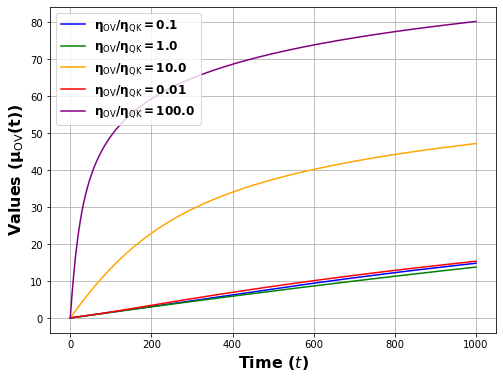

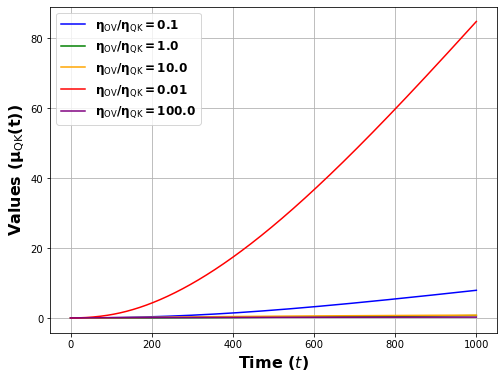

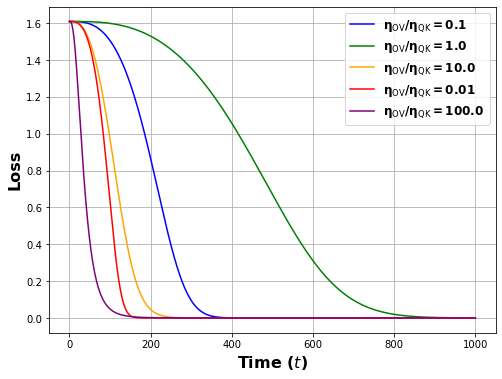

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Parameters
m, n, b, M = 10, 3, 10, 5
dt = 0.001
base_T = 1000  # Base simulation time

# Differential equations
def dmu_dt(mu, nu, eta1):
    alpha = np.exp(nu) / (m * np.exp(nu) + n)
    return (eta1 * alpha * m) / (b * (np.exp(alpha * mu) + M - 1))

def dnu_dt(mu, nu, eta2):
    alpha = np.exp(nu) / (m * np.exp(nu) + n)
    return (eta2 * (M - 1) * (alpha - alpha**2 * (b / m)) * mu) / (b**2 * M * (np.exp(alpha * mu) + M - 1))

# Simulation runner with loss tracking
def run_simulation(eta1, eta2):
    T = base_T / min(eta1, eta2)  # Increase time for slower eta
    steps = int(T / dt)

    mu = np.zeros(steps)
    nu = np.zeros(steps)
    loss = np.zeros(steps)
    mu[0] = 0
    nu[0] = 0
    loss[0] = np.log(1 + (M - 1))  # At t=0, mu=nu=0 -> logits=0

    time = np.linspace(0, T, steps)

    for i in range(steps - 1):
        mu[i+1] = mu[i] + dmu_dt(mu[i], nu[i], eta1) * dt
        nu[i+1] = nu[i] + dnu_dt(mu[i], nu[i], eta2) * dt
        logits = mu[i+1] * nu[i+1]
        loss[i+1] = np.log(1 + (M - 1) / np.exp(logits))  # Softmax cross-entropy

    time_norm = time * min(eta1, eta2)  # Normalize time by minimum eta

    print(f"=== Results for η1={eta1}, η2={eta2} ===")
    print(f"mu: [{mu[0]:.3f}, {mu[steps//2]:.3f}, {mu[-1]:.3f}], "
          f"nu: [{nu[0]:.3f}, {nu[steps//2]:.3f}, {nu[-1]:.3f}], "
          f"loss: [{loss[0]:.3f}, {loss[steps//2]:.3f}, {loss[-1]:.3f}]")

    return time, time_norm, mu, nu, loss

# Eta pairs and color mapping
eta_pairs = [ (0.1, 1), (1, 1), (10, 1), (0.1, 10), (10, 0.1) ]
colors = { (0.1, 1): 'blue', (1, 1): 'green', (10, 1): 'orange', (0.1, 10): 'red', (10, 0.1): 'purple' }

# Font properties
font_properties = fm.FontProperties(weight='bold', size=12)

# Run simulations and store results
results = {}
for eta1, eta2 in eta_pairs:
    time, time_norm, mu, nu, loss = run_simulation(eta1, eta2)
    results[(eta1, eta2)] = (time, time_norm, mu, nu, loss)

# Plot μ (mu) over normalized time
plt.figure(figsize=(8, 6))
for key in eta_pairs:
    _, time_norm, mu, _, _ = results[key]
    ratio = key[0] / key[1]
    plt.plot(time_norm, mu, label=rf'$\bf{{\eta_{{\mathrm{{OV}}}}/\eta_{{\mathrm{{QK}}}} = {ratio}}}$',  color=colors[key])
plt.xlabel(r"Time ($t$)", fontsize=16, fontweight='bold')
plt.ylabel(r"Values ($ \bf \mu_{\mathrm{OV}}(t)$)", fontsize=16, fontweight='bold')
plt.legend(fontsize=14, prop=font_properties, loc='upper left')
plt.grid()
plt.savefig("mu_t.pdf", bbox_inches='tight')
plt.show()

# Plot ν (nu) over normalized time
plt.figure(figsize=(8, 6))
for key in eta_pairs:
    _, time_norm, _, nu, _ = results[key]
    ratio = key[0] / key[1]
    plt.plot(time_norm, nu, label=rf'$\bf{{\eta_{{\mathrm{{OV}}}}/\eta_{{\mathrm{{QK}}}} = {ratio}}}$',  color=colors[key])
plt.xlabel(r"Time ($t$)", fontsize=16, fontweight='bold')
plt.ylabel(r"Values ($\bf \mu_{\mathrm{QK}}(t)$)", fontsize=16, fontweight='bold')
plt.legend(fontsize=14, prop=font_properties, loc='upper left')
plt.grid()
plt.savefig("nu_t.pdf", bbox_inches='tight')
plt.show()

# Plot Loss over normalized time
plt.figure(figsize=(8, 6))
for key in eta_pairs:
    _, time_norm, _, _, loss = results[key]
    ratio = key[0] / key[1]
    plt.plot(time_norm, loss, 
         label=rf'$\bf{{\eta_{{\mathrm{{OV}}}}/\eta_{{\mathrm{{QK}}}} = {ratio}}}$', 
         color=colors[key])
plt.xlabel(r"Time ($t$)", fontsize=16, fontweight='bold') 
plt.ylabel("Loss", fontsize=16, fontweight='bold')
plt.legend(fontsize=14, prop=font_properties, loc='upper right')
plt.grid()
plt.savefig("loss_t.pdf", bbox_inches='tight')
plt.show()

In [5]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [6]:
values = [[0.0, 0.0,0.0,0.0,0.0],[0.0, 0.0,0.0,0.0,0.0],[0.0, 0.0,0.0,0.0,0.0],
          [0.0, 0.2,0.0,0.0,0.0],[0.0, 0.0,2.6,86.9,10.5]]

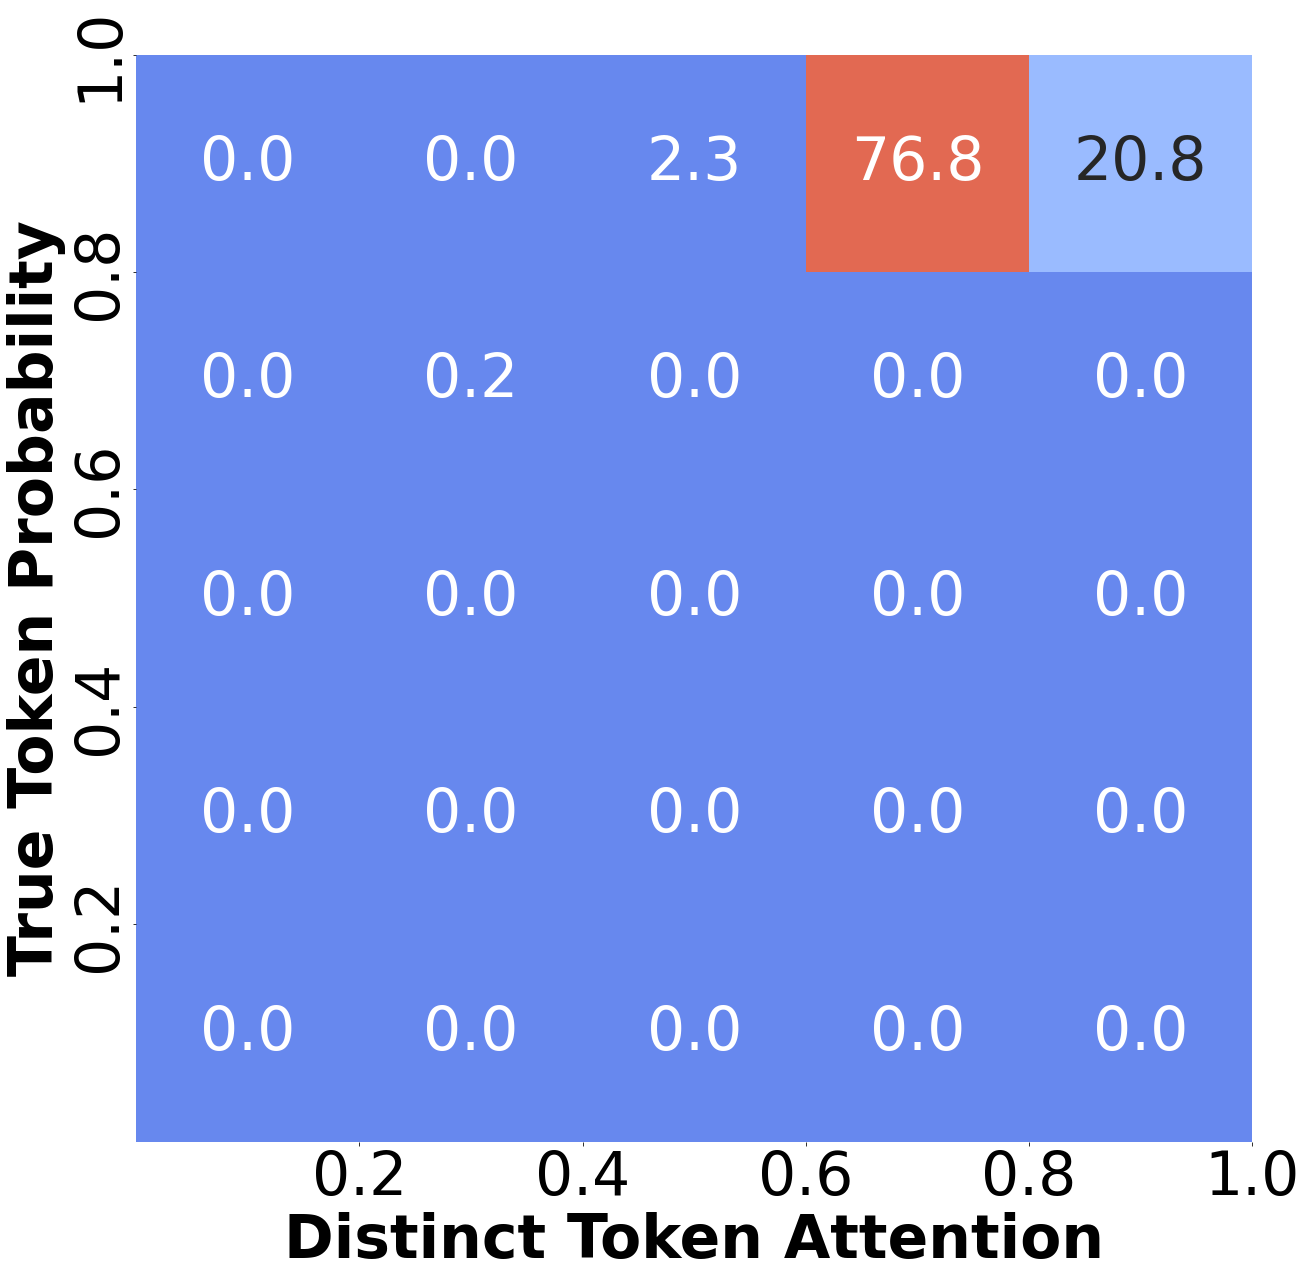

In [8]:
# Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.2, 0.4, 0.6, 0.8,1])
y_edges = np.array([0, 0.2, 0.4, 0.6, 0.8,1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(20, 20))
ax = sns.heatmap(values, annot=values, cmap=sns.color_palette("coolwarm"), 
                 annot_kws={"size":60}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# Make the tick labels bold
ax.tick_params(axis='x', labelsize=60)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=60)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=60)
plt.ylabel(r"True Token Probability", fontweight="bold", fontsize=60)
#plt.title("Mean (±Std Dev) Heatmap")

# Save the figure
plt.savefig("params_increasing_caco.pdf", bbox_inches='tight')
plt.show()